<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Minutes-and-Statements" data-toc-modified-id="Minutes-and-Statements-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Minutes and Statements</a></span></li><li><span><a href="#Measuring-the-Distance" data-toc-modified-id="Measuring-the-Distance-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Measuring the Distance</a></span></li><li><span><a href="#Policy-Rate-Change-and-Market-Reaction" data-toc-modified-id="Policy-Rate-Change-and-Market-Reaction-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Policy Rate Change and Market Reaction</a></span></li><li><span><a href="#Feature-Selection-and-Sentiment" data-toc-modified-id="Feature-Selection-and-Sentiment-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Feature Selection and Sentiment</a></span></li></ul></div>

In [1]:
import datetime
import re
from collections import Counter
from os import listdir

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import spacy
import swifter
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.test.utils import get_tmpfile
from nltk.tokenize import word_tokenize
# nltk.download('punkt')

d:\software\python\lib\site-packages\cupy\_environment.py:213: UserWarning: CUDA path could not be detected. Set CUDA_PATH environment variable if CuPy fails to load.
  warnings.warn(
d:\software\python\lib\site-packages\cupy\_environment.py:213: UserWarning: CUDA path could not be detected. Set CUDA_PATH environment variable if CuPy fails to load.
  warnings.warn(
d:\software\python\lib\site-packages\cupy\_environment.py:213: UserWarning: CUDA path could not be detected. Set CUDA_PATH environment variable if CuPy fails to load.
  warnings.warn(
d:\software\python\lib\site-packages\cupy\_environment.py:213: UserWarning: CUDA path could not be detected. Set CUDA_PATH environment variable if CuPy fails to load.
  warnings.warn(


In [2]:
nlp = spacy.load("en_core_web_sm")
all_stopwords = nlp.Defaults.stop_words
all_stopwords |= {'the', 'is', 'th', 's', 'm', 'would'}

In [3]:
def my_tokenizer(doc):
    text = word_tokenize(doc)
    tokens_without_sw = [word for word in text if not word in all_stopwords]

    return tokens_without_sw

In [4]:
def preprocess_tokens(tokens):
    '''
    Remove any extra lines, non-letter characters, and blank quotes
    '''
    remove_new_lines = [re.sub('\s+', '', token) for token in tokens]
    #Remove non letter characters
    non_letters = [re.sub('[^a-zA-Z]', '', remove_new_line) for remove_new_line in remove_new_lines]
    #Remove distracting single quotes
    remove_quotes = [re.sub("\'", '', non_letter) for non_letter in non_letters]
    #Removes empty strings from a list of strings
    final = list(filter(None, remove_quotes))

    return final

In [5]:
def get_words(full_text):
    raw = [word.lower() for word in full_text.split()]

    values = ','.join(map(str, raw))  #converts bytes object to string
    tokenizer = my_tokenizer(values)

    words = preprocess_tokens(tokenizer)
    # remove stopwords
    stops = nltk.corpus.stopwords.words('english')
    new_stopwords = ['chairman', 'would', 'mr']
    stops.extend(new_stopwords)
    words = [word for word in words if word not in stops]
    counter = Counter()
    counter.update(words)
    most_common = counter.most_common(25)

    return words, most_common

### Minutes and Statements

The data is collected from 

In [6]:
dates_statements, dates_minutes = [], []
with open('data\calendars_statements.txt', 'r') as f:
    for line in f.readlines():
        line = line.replace('\n', '')
        dates_statements.append(pd.to_datetime(line))
with open('data\calendars_minutes.txt', 'r') as f:
    for line in f.readlines():
        line = line.replace('\n', '')
        dates_minutes.append(pd.to_datetime(line))
dates_minutes = pd.DataFrame(dates_minutes)
dates_statements = pd.DataFrame(dates_statements)
dates_minutes, dates_statements

(             0
 0   1994-02-04
 1   1994-03-22
 2   1994-05-17
 3   1994-07-06
 4   1994-08-16
 ..         ...
 217 2021-03-17
 218 2021-04-28
 219 2021-06-16
 220 2021-07-28
 221 2021-09-22
 
 [222 rows x 1 columns],
              0
 0   1994-02-04
 1   1994-03-22
 2   1994-05-17
 3   1994-08-16
 4   1994-11-15
 ..         ...
 187 2021-03-17
 188 2021-04-28
 189 2021-06-16
 190 2021-07-28
 191 2021-09-22
 
 [192 rows x 1 columns])

In [7]:
statements = []
with open('data\calendars_statements.txt', 'r') as f:
    for line in f.readlines():
        line = line.replace('\n', '')
        with open(r'data/statements/' + line + r'.txt', encoding='utf8', errors='ignore') as g:
            s = g.read().replace('\n', '').replace('\\xad', '')
            statements.append(s)
statements = pd.DataFrame(statements, columns=["statements"])
statements

,statements
0,Chairman Alan Greenspan announced today that t...
1,Chairman Alan Greenspan announced today that t...
2,The Federal Reserve today announced two action...
3,The Federal Reserve announced today the follow...
4,The Federal Reserve Board today approved an in...
...,...
187,The Federal Reserve is committed to using its ...
188,The Federal Reserve is committed to using its ...
189,The Federal Reserve is committed to using its ...
190,The Federal Reserve is committed to using its ...


In [8]:
minutes = []
with open('data\calendars_statements.txt', 'r') as f:
    for line in f.readlines():
        line = line.replace('\n', '')
        with open(r'data/minutes/FOMC_' + line + r'.txt', encoding='utf8', errors='ignore') as g:
            m = g.read().replace('\n', ' ').replace('\xad', '')
            minutes.append(m)
minutes = pd.DataFrame(minutes, columns=["minutes"])
minutes

,minutes
0,The information reviewed at this meeting indic...
1,The information reviewed at this meeting indic...
2,The information reviewed at this meeting sugge...
3,The information reviewed at this meeting sugge...
4,The information reviewed at this meeting sugge...
...,...
187,Staff Review of the Economic Situation The COV...
188,Staff Review of the Economic Situation The COV...
189,Staff Review of the Economic Situation The inf...
190,Staff Review of the Economic Situation The inf...


In [9]:
df_minutes = pd.concat([dates_statements, minutes], axis=1)
df_minutes.columns = ['date', 'minutes']
df_minutes.head()

,date,minutes
0,1994-02-04,The information reviewed at this meeting indic...
1,1994-03-22,The information reviewed at this meeting indic...
2,1994-05-17,The information reviewed at this meeting sugge...
3,1994-08-16,The information reviewed at this meeting sugge...
4,1994-11-15,The information reviewed at this meeting sugge...


In [10]:
df_statements = pd.concat([dates_statements, statements], axis=1)
df_statements.columns = ['date', 'statements']
df_statements.head()

,date,statements
0,1994-02-04,Chairman Alan Greenspan announced today that t...
1,1994-03-22,Chairman Alan Greenspan announced today that t...
2,1994-05-17,The Federal Reserve today announced two action...
3,1994-08-16,The Federal Reserve announced today the follow...
4,1994-11-15,The Federal Reserve Board today approved an in...


In [11]:
df_minutes["all_words_minutes"] = df_minutes["minutes"].swifter.apply(lambda x: get_words(x)[0])
df_minutes["top_tokens"] = df_minutes["minutes"].swifter.apply(lambda x: get_words(x)[1])
df_minutes

Pandas Apply:   0%|          | 0/192 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/192 [00:00<?, ?it/s]

,date,minutes,all_words_minutes,top_tokens
0,1994-02-04,The information reviewed at this meeting indic...,"[information, reviewed, meeting, indicated, ec...","[(growth, 56), (committee, 47), (economic, 40)..."
1,1994-03-22,The information reviewed at this meeting indic...,"[information, reviewed, meeting, indicated, ec...","[(policy, 35), (members, 35), (february, 33), ..."
2,1994-05-17,The information reviewed at this meeting sugge...,"[information, reviewed, meeting, suggested, ec...","[(growth, 29), (april, 27), (prices, 25), (pol..."
3,1994-08-16,The information reviewed at this meeting sugge...,"[information, reviewed, meeting, suggested, pa...","[(growth, 38), (july, 26), (quarter, 26), (mem..."
4,1994-11-15,The information reviewed at this meeting sugge...,"[information, reviewed, meeting, suggested, gr...","[(growth, 33), (policy, 26), (business, 24), (..."
...,...,...,...,...
187,2021-03-17,Staff Review of the Economic Situation The COV...,"[staff, review, economic, situation, covid, pa...","[(participants, 54), (inflation, 51), (january..."
188,2021-04-28,Staff Review of the Economic Situation The COV...,"[staff, review, economic, situation, covid, pa...","[(participants, 51), (inflation, 44), (remaine..."
189,2021-06-16,Staff Review of the Economic Situation The inf...,"[staff, review, economic, situation, informati...","[(inflation, 65), (participants, 65), (economi..."
190,2021-07-28,Staff Review of the Economic Situation The inf...,"[staff, review, economic, situation, informati...","[(inflation, 67), (participants, 63), (remaine..."


In [12]:
df_statements["all_words_statements"] = df_statements["statements"].swifter.apply(lambda x: get_words(x)[0])
df_statements["top_tokens"] = df_statements["statements"].swifter.apply(lambda x: get_words(x)[1])
df_statements

Pandas Apply:   0%|          | 0/192 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/192 [00:00<?, ?it/s]

,date,statements,all_words_statements,top_tokens
0,1994-02-04,Chairman Alan Greenspan announced today that t...,"[alan, greenspan, announced, today, federal, o...","[(market, 3), (committee, 3), (greenspan, 2), ..."
1,1994-03-22,Chairman Alan Greenspan announced today that t...,"[alan, greenspan, announced, today, federal, o...","[(market, 2), (increase, 2), (alan, 1), (green..."
2,1994-05-17,The Federal Reserve today announced two action...,"[federal, reserve, today, announced, actions, ...","[(federal, 5), (reserve, 5), (discount, 3), (r..."
3,1994-08-16,The Federal Reserve announced today the follow...,"[federal, reserve, announced, today, following...","[(federal, 4), (reserve, 4), (actions, 3), (ec..."
4,1994-11-15,The Federal Reserve Board today approved an in...,"[federal, reserve, board, today, approved, inc...","[(federal, 5), (reserve, 5), (rate, 5), (disco..."
...,...,...,...,...
187,2021-03-17,The Federal Reserve is committed to using its ...,"[federal, reserve, committed, range, tools, su...","[(inflation, 10), (committee, 10), (percent, 8..."
188,2021-04-28,The Federal Reserve is committed to using its ...,"[federal, reserve, committed, range, tools, su...","[(committee, 10), (inflation, 9), (percent, 7)..."
189,2021-06-16,The Federal Reserve is committed to using its ...,"[federal, reserve, committed, range, tools, su...","[(committee, 10), (inflation, 9), (percent, 7)..."
190,2021-07-28,The Federal Reserve is committed to using its ...,"[federal, reserve, committed, range, tools, su...","[(committee, 11), (inflation, 9), (percent, 7)..."


In [13]:
#Count the total word frequency of statements
word_df_statements = pd.DataFrame(columns=['Words', 'Count'])
for i in range(len(df_statements)):  #total links
    word_count = {'Words': [], 'Count': []}
    for sets in df_statements['top_tokens'][i]:
        # print(files)  #total pairs
        word_count['Words'].append(sets[0])  #total words broken out
        word_count['Count'].append(sets[1])  #total count per word    
    word_df1_statements = pd.DataFrame(word_count)
    word_df_statements = word_df_statements.append(word_df1_statements, ignore_index=True)

total_words_statements = word_df_statements.groupby(['Words']).sum()
sorted_top_words_statements = total_words_statements.sort_values(by='Count', ascending=False)
sorted_top_words_1 = sorted_top_words_statements[:25]
sorted_top_words_1

,Count
Words,
committee,1435
inflation,1102
economic,778
federal,771
rate,667
market,609
policy,545
percent,434
conditions,390


In [14]:
#Count the total word frequency of minutes
word_df_minutes = pd.DataFrame(columns=['Words', 'Count'])
for i in range(len(df_minutes)):  #total links
    word_count = {'Words': [], 'Count': []}
    for sets in df_minutes['top_tokens'][i]:
        # print(files)  #total pairs
        word_count['Words'].append(sets[0])  #total words broken out
        word_count['Count'].append(sets[1])  #total count per word    
    word_df1_minutes = pd.DataFrame(word_count)
    word_df_minutes = word_df_minutes.append(word_df1_minutes, ignore_index=True)

total_words_minutes = word_df_minutes.groupby(['Words']).sum()
sorted_top_words_minutes = total_words_minutes.sort_values(by='Count', ascending=False)
sorted_top_words_2 = sorted_top_words_minutes[:25]
sorted_top_words_2

,Count
Words,
inflation,6957
economic,5844
participants,4903
rate,4605
growth,4273
prices,3694
committee,3684
market,3679
policy,3319


Text(0.5, 0, 'Total number of occurences')

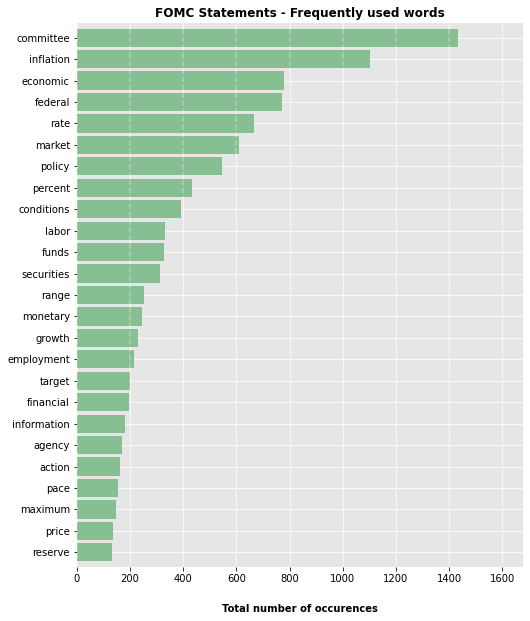

In [15]:
sorted_top_words_1 = sorted_top_words_1.sort_values(by="Count")
sorted_top_words_2 = sorted_top_words_2.sort_values(by="Count")

plt.rc('axes', facecolor='#E6E6E6', edgecolor='none', axisbelow=True, grid=True)
plt.rc('grid', color='w', linestyle='solid')

ax = sorted_top_words_1.plot(kind='barh', figsize=(8, 10), color='#86bf91', width=0.85)

ax.get_legend().remove()
plt.title("FOMC Statements - Frequently used words", fontsize=12, weight='bold')
# Draw vertical axis lines
vals = ax.get_xticks()
for tick in vals:
    ax.axvline(x=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

# Set axis labels
ax.yaxis.label.set_visible(False)
ax.set_xlabel("Total number of occurences", labelpad=20, weight='bold', size=10)

Text(0.5, 0, 'Total number of occurences')

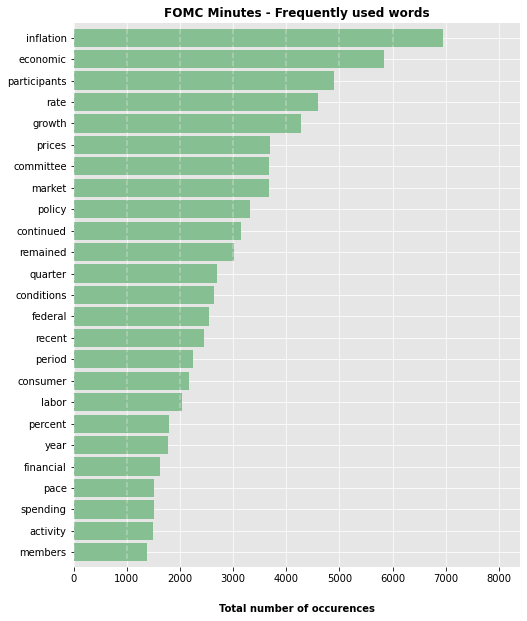

In [16]:
plt.rc('axes', facecolor='#E6E6E6', edgecolor='none',
       axisbelow=True, grid=True)
plt.rc('grid', color='w', linestyle='solid')

ax = sorted_top_words_2.plot(kind='barh', figsize=(8, 10), color='#86bf91', width=0.85)

ax.get_legend().remove()
plt.title("FOMC Minutes - Frequently used words", fontsize=12, weight='bold')
# Draw vertical axis lines
vals = ax.get_xticks()
for tick in vals:
    ax.axvline(x=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

# Set axis labels

ax.yaxis.label.set_visible(False)
ax.set_xlabel("Total number of occurences", labelpad=20, weight='bold', size=10)

In [17]:
LM_list = pd.read_excel("LM Word List.xlsx")

In [18]:
word_list = []
for sentiment_class in ["Negative", "Positive", "Uncertainty", "Litigious", "Strong_Modal", "Weak_Modal",
                        "Constraining"]:
    sentiment_list = LM_list[LM_list[sentiment_class] > 0]["Word"].str.lower()
    word_list.append(sentiment_list)
word_list = pd.concat(word_list, axis=1, sort=True).fillna(" ")
word_list.columns = ["Negative", "Positive", "Uncertainty", "Litigious", "Strong_Modal", "Weak_Modal", "Constraining"]
word_list.reset_index(drop=True, inplace=True)
word_list

,Negative,Positive,Uncertainty,Litigious,Strong_Modal,Weak_Modal,Constraining
0,abandon,,,,,,
1,abandoned,,,,,,
2,abandoning,,,,,,
3,abandonment,,,,,,
4,abandonments,,,,,,
...,...,...,...,...,...,...,...
3854,wrongdoing,,,,,,
3855,wrongdoings,,,,,,
3856,wrongful,,,,,,
3857,wrongfully,,,,,,


In [19]:
word_list = word_list.to_dict('list')  #create a dictionary out of the excel list and use it to map the transcripts
word_list

{'Negative': ['abandon',
  'abandoned',
  'abandoning',
  'abandonment',
  'abandonments',
  'abandons',
  'abdicated',
  'abdicates',
  'abdicating',
  'abdication',
  'abdications',
  'aberrant',
  'aberration',
  'aberrational',
  'aberrations',
  'abetting',
  ' ',
  ' ',
  ' ',
  ' ',
  ' ',
  'abnormal',
  'abnormalities',
  'abnormality',
  'abnormally',
  'abolish',
  'abolished',
  'abolishes',
  'abolishing',
  ' ',
  'abrogate',
  'abrogated',
  'abrogates',
  'abrogating',
  'abrogation',
  'abrogations',
  'abrupt',
  'abruptly',
  'abruptness',
  'absence',
  'absences',
  'absenteeism',
  ' ',
  ' ',
  ' ',
  ' ',
  ' ',
  ' ',
  'abuse',
  'abused',
  'abuses',
  'abusing',
  'abusive',
  'abusively',
  'abusiveness',
  ' ',
  ' ',
  'accident',
  'accidental',
  'accidentally',
  'accidents',
  ' ',
  ' ',
  ' ',
  ' ',
  ' ',
  ' ',
  ' ',
  'accusation',
  'accusations',
  'accuse',
  'accused',
  'accuses',
  'accusing',
  ' ',
  ' ',
  ' ',
  ' ',
  ' ',
  ' ',
  '

In [20]:
negate = ["aint", "arent", "cannot", "cant", "couldnt", "darent", "didnt", "doesnt", "ain't", "aren't", "can't",
          "couldn't", "daren't", "didn't", "doesn't", "dont", "hadnt", "hasnt", "havent", "isnt", "mightnt", "mustnt",
          "neither", "don't", "hadn't", "hasn't", "haven't", "isn't", "mightn't", "mustn't", "neednt", "needn't",
          "never", "none", "nope", "nor", "not", "nothing", "nowhere", "oughtnt", "shant", "shouldnt", "wasnt",
          "werent", "oughtn't", "shan't", "shouldn't", "wasn't", "weren't", "without", "wont", "wouldnt", "won't",
          "wouldn't", "rarely", "seldom", "despite", "no", "nobody"]


def negated(word):
    """
    Determine if preceding word is a negation word
    """
    if word.lower() in negate:
        return True
    else:
        return False

In [21]:
def count_with_negation(fin_dict, transcript):
    """
    Count positive and negative words with negation check. Account for simple negation only for positive words.
    negation is occurring within three words preceding a positive words.
    """
    pos_count = 0
    neg_count = 0

    pos_words = []
    neg_words = []

    input_words = re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', transcript.lower())

    word_count = len(input_words)

    for i in range(0, word_count):
        if input_words[i] in fin_dict['Negative']:
            neg_count += 1
            neg_words.append(input_words[i])
        if input_words[i] in fin_dict['Positive']:
            if i >= 3:
                if negated(input_words[i - 1]) or negated(input_words[i - 2]) or negated(input_words[i - 3]):
                    neg_count += 1
                    neg_words.append(input_words[i] + ' (with negation)')
                else:
                    pos_count += 1
                    pos_words.append(input_words[i])
            elif i == 2:
                if negated(input_words[i - 1]) or negated(input_words[i - 2]):
                    neg_count += 1
                    neg_words.append(input_words[i] + ' (with negation)')
                else:
                    pos_count += 1
                    pos_words.append(input_words[i])
            elif i == 1:
                if negated(input_words[i - 1]):
                    neg_count += 1
                    neg_words.append(input_words[i] + ' (with negation)')
                else:
                    pos_count += 1
                    pos_words.append(input_words[i])
            elif i == 0:
                pos_count += 1
                pos_words.append(input_words[i])

    results = [word_count, pos_count, neg_count, pos_words, neg_words]

    return results

In [22]:
temp = df_statements["statements"].swifter.apply(lambda x: count_with_negation(word_list, x))

Pandas Apply:   0%|          | 0/192 [00:00<?, ?it/s]

In [23]:
temp = pd.DataFrame.from_records(temp)
df_statements = pd.concat([df_statements, temp], axis=1)
df_statements.set_index('date', inplace=True)
df_statements.columns = ['statements', 'all_words_statements', 'top_tokens', 'wordcount',
                         'NPositiveWords', 'NNegativeWords', 'Poswords', 'Negwords']
df_statements

,statements,all_words_statements,top_tokens,wordcount,NPositiveWords,NNegativeWords,Poswords,Negwords
date,,,,,,,,
1994-02-04,Chairman Alan Greenspan announced today that t...,"[alan, greenspan, announced, today, federal, o...","[(market, 3), (committee, 3), (greenspan, 2), ...",99,1,1,[enhance],[misunderstanding]
1994-03-22,Chairman Alan Greenspan announced today that t...,"[alan, greenspan, announced, today, federal, o...","[(market, 2), (increase, 2), (alan, 1), (green...",40,0,0,[],[]
1994-05-17,The Federal Reserve today announced two action...,"[federal, reserve, today, announced, actions, ...","[(federal, 5), (reserve, 5), (discount, 3), (r...",160,1,0,[favorable],[]
1994-08-16,The Federal Reserve announced today the follow...,"[federal, reserve, announced, today, following...","[(federal, 4), (reserve, 4), (actions, 3), (ec...",137,1,1,[strength],[against]
1994-11-15,The Federal Reserve Board today approved an in...,"[federal, reserve, board, today, approved, inc...","[(federal, 5), (reserve, 5), (rate, 5), (disco...",139,1,2,[strength],"[against, persistent]"
...,...,...,...,...,...,...,...,...
2021-03-17,The Federal Reserve is committed to using its ...,"[federal, reserve, committed, range, tools, su...","[(inflation, 10), (committee, 10), (percent, 8...",474,10,8,"[stability, tremendous, progress, achieve, ach...","[challenging, hardship, adversely, weak, crisi..."
2021-04-28,The Federal Reserve is committed to using its ...,"[federal, reserve, committed, range, tools, su...","[(committee, 10), (inflation, 9), (percent, 7)...",471,14,7,"[stability, tremendous, progress, strong, stre...","[challenging, hardship, adversely, weak, crisi..."
2021-06-16,The Federal Reserve is committed to using its ...,"[federal, reserve, committed, range, tools, su...","[(committee, 10), (inflation, 9), (percent, 7)...",469,14,6,"[stability, progress, progress, strong, streng...","[challenging, adversely, weak, crisis, persist..."


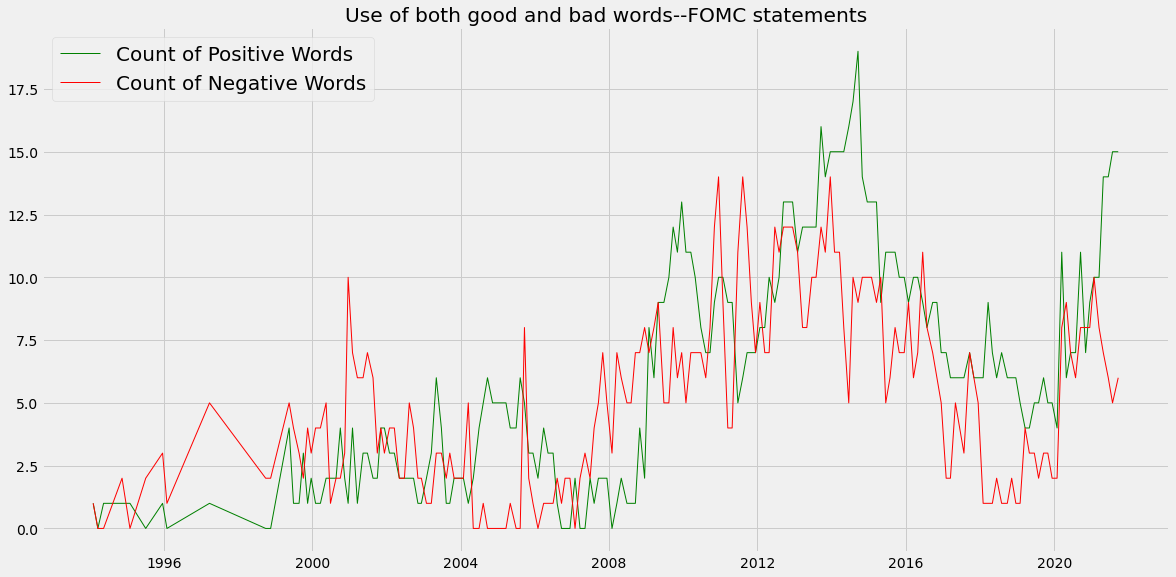

In [24]:
plt.rcParams["figure.figsize"] = (18, 9)
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots()
ax.plot(df_statements.index, df_statements['NPositiveWords'], c='green', linewidth=1.0)
plt.plot(df_statements.index, df_statements['NNegativeWords'], c='red', linewidth=1.0)
plt.title('Use of both good and bad words--FOMC statements')
plt.legend(['Count of Positive Words', 'Count of Negative Words'], prop={'size': 20}, loc=2)

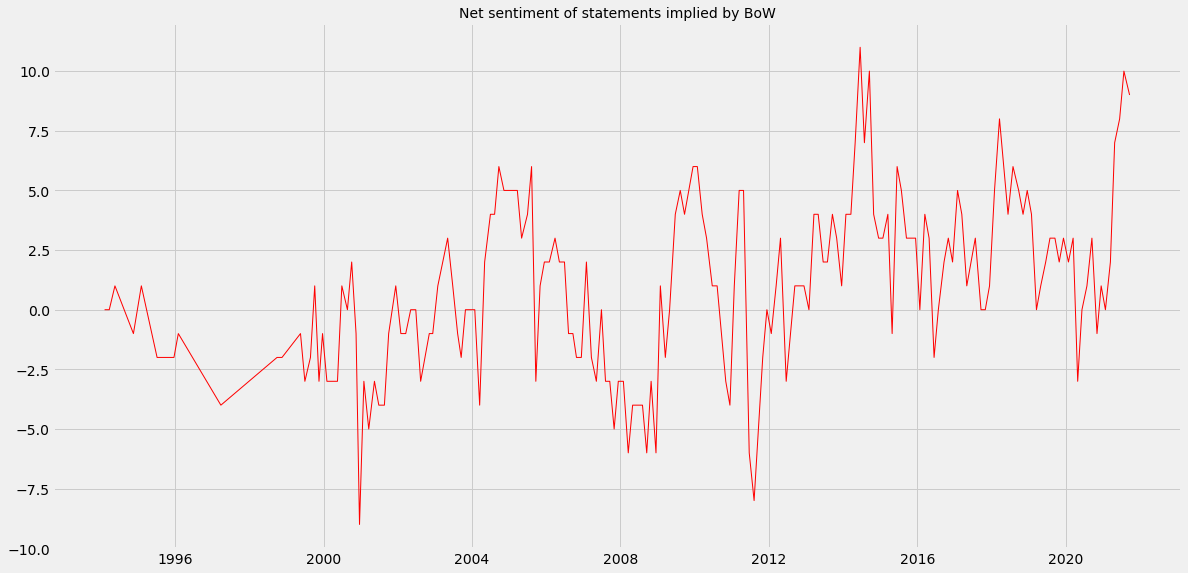

In [25]:
NetSentiment = (df_statements['NPositiveWords'] - df_statements['NNegativeWords'])
fig, ax = plt.subplots()
ax.plot(df_statements.index, NetSentiment, c='red', linewidth=1.0)
plt.title('Net sentiment of statements implied by BoW', size='medium')
plt.show()

In [26]:
temp = df_minutes["minutes"].swifter.apply(lambda x: count_with_negation(word_list, x))

Pandas Apply:   0%|          | 0/192 [00:00<?, ?it/s]

In [27]:
temp = pd.DataFrame.from_records(temp)
df_minutes = pd.concat([df_minutes, temp], axis=1)
df_minutes.set_index('date', inplace=True)
df_minutes.columns = ['minutes', 'all_words_minutes', 'top_tokens', 'wordcount',
                      'NPositiveWords', 'NNegativeWords', 'Poswords', 'Negwords']
df_minutes

,minutes,all_words_minutes,top_tokens,wordcount,NPositiveWords,NNegativeWords,Poswords,Negwords
date,,,,,,,,
1994-02-04,The information reviewed at this meeting indic...,"[information, reviewed, meeting, indicated, ec...","[(growth, 56), (committee, 47), (economic, 40)...",6246,92,97,"[strong, gains, strengthened, strengthening, g...","[complicated, problems, adverse, severe, unemp..."
1994-03-22,The information reviewed at this meeting indic...,"[information, reviewed, meeting, indicated, ec...","[(policy, 35), (members, 35), (february, 33), ...",4674,59,105,"[despite, strong, gain, rebounded, despite, hi...","[severe, adverse, declined, declined, vulnerab..."
1994-05-17,The information reviewed at this meeting sugge...,"[information, reviewed, meeting, suggested, ec...","[(growth, 29), (april, 27), (prices, 25), (pol...",4434,65,104,"[favorable, stronger, gains, strong, rebound, ...","[sharply, severe, losses, slower, unemployment..."
1994-08-16,The information reviewed at this meeting sugge...,"[information, reviewed, meeting, suggested, pa...","[(growth, 38), (july, 26), (quarter, 26), (mem...",4300,47,79,"[gains, favorable, strong, gain, despite, popu...","[slowed, volatile, unemployment, decline, slow..."
1994-11-15,The information reviewed at this meeting sugge...,"[information, reviewed, meeting, suggested, gr...","[(growth, 33), (policy, 26), (business, 24), (...",4463,61,66,"[strong, despite, strong, gains, gains, advanc...","[tightening, slowed, unemployment, declined, p..."
...,...,...,...,...,...,...,...,...
2021-03-17,Staff Review of the Economic Situation The COV...,"[staff, review, economic, situation, covid, pa...","[(participants, 54), (inflation, 51), (january...",6048,94,107,"[improved, gains, boosted, stronger, gain, boo...","[losses, unemployment, unemployment, declined,..."
2021-04-28,Staff Review of the Economic Situation The COV...,"[staff, review, economic, situation, covid, pa...","[(participants, 51), (inflation, 44), (remaine...",5539,92,121,"[improved, gain, exceptionally, boosted, boost...","[losses, unemployment, declined, layoff, layof..."
2021-06-16,Staff Review of the Economic Situation The inf...,"[staff, review, economic, situation, informati...","[(inflation, 65), (participants, 65), (economi...",6006,97,104,"[improved, gains, gains, boosted, stronger, ga...","[slower, losses, unemployment, unemployment, c..."


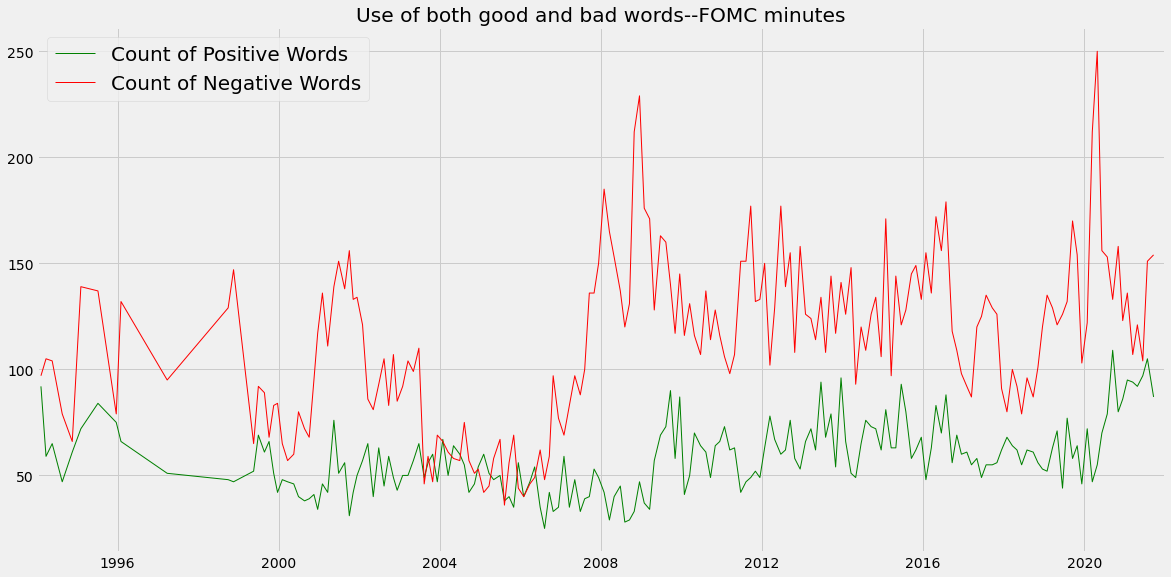

In [28]:
plt.rcParams["figure.figsize"] = (18, 9)
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots()
ax.plot(df_minutes.index, df_minutes['NPositiveWords'], c='green', linewidth=1.0)
plt.plot(df_minutes.index, df_minutes['NNegativeWords'], c='red', linewidth=1.0)
plt.title('Use of both good and bad words--FOMC minutes')
plt.legend(['Count of Positive Words', 'Count of Negative Words'], prop={'size': 20}, loc=2)

years = mdates.YearLocator()  # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%Y')

datemin = np.datetime64(df_minutes.index[0], 'Y')
datemax = np.datetime64(df_minutes.index[-1], 'Y') + np.timedelta64(1, 'Y')
ax.set_xlim(datemin, datemax)
# format the coords message box
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.grid(True)

plt.savefig('fomc_correlated_words_minutes.png', dpi=60, bbox_inches="tight")
plt.show()

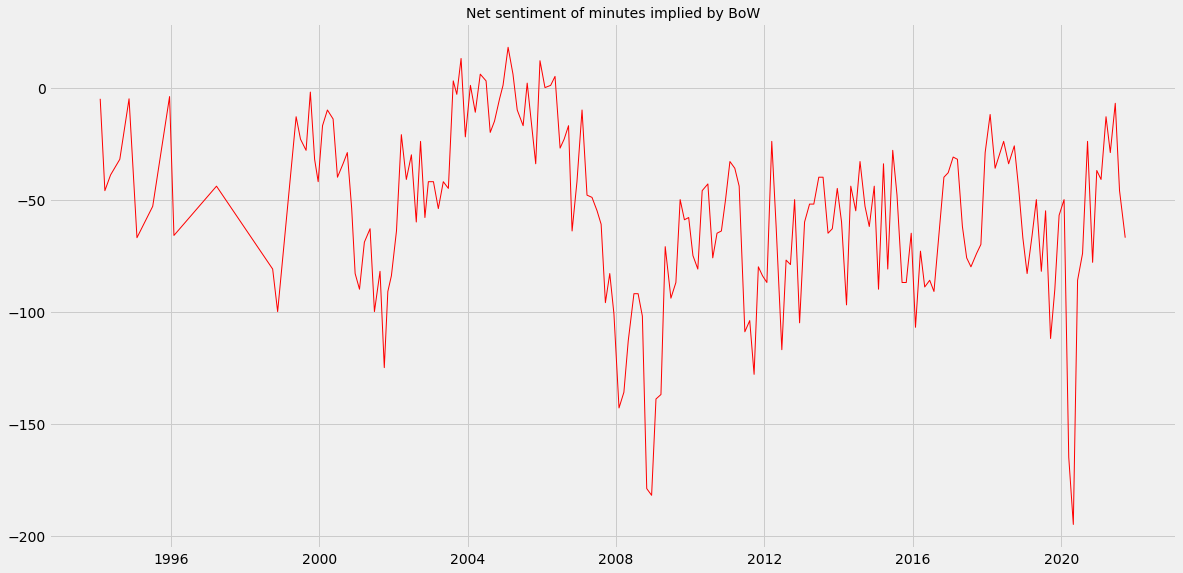

In [29]:
NetSentiment = (df_minutes['NPositiveWords'] - df_minutes['NNegativeWords'])
fig, ax = plt.subplots()
ax.plot(df_minutes.index, NetSentiment, c='red', linewidth=1.0)
plt.title('Net sentiment of minutes implied by BoW', size='medium')
plt.show()

### Measuring the Distance

In [30]:
docLabels_1 = [f for f in listdir("data/statements") if f.endswith('.txt')]
docLabels_2 = [f for f in listdir("data/minutes") if f.endswith('.txt') and f.strip('FOMC_') in docLabels_1]

In [31]:
data_1 = [
    TaggedDocument(get_words(open('data/statements/' + doc, 'r', encoding='utf8', errors='ignore').read())[0], [i])
    for i, doc in enumerate(docLabels_1)]
data_2 = [
    TaggedDocument(get_words(open('data/minutes/' + doc, 'r', encoding='utf8', errors='ignore').read())[0], [i + 192])
    for i, doc in enumerate(docLabels_2)]

In [32]:
data = data_1 + data_2

In [33]:
model = Doc2Vec(data, vector_size=50, window=1, min_count=1, workers=12)
fname = get_tmpfile("doc2vec_model")
model.save(fname)

In [34]:
model = Doc2Vec.load(fname)
Distance = []
with open('data\calendars_statements.txt', 'r') as f:
    i = 1
    for l in f.readlines():
        line = l.replace('\n', '')
        print('Distance between statements and minutes for the FOMC on date:',
              pd.to_datetime(line).strftime("%Y-%m-%d"))
        Distance.append(model.wv.distance(i, i + 192))
        print(model.wv.distance(i, i + 192))
        i += 1
Distance = pd.Series(Distance)

Distance between statements and minutes for the FOMC on date: 1994-02-04
0.9516130797564983
Distance between statements and minutes for the FOMC on date: 1994-03-22
0.9478490948677063
Distance between statements and minutes for the FOMC on date: 1994-05-17
0.7935747057199478
Distance between statements and minutes for the FOMC on date: 1994-08-16
0.7019884884357452
Distance between statements and minutes for the FOMC on date: 1994-11-15
0.7704432904720306
Distance between statements and minutes for the FOMC on date: 1995-02-01
0.9112272039055824
Distance between statements and minutes for the FOMC on date: 1995-07-06
0.8742737472057343
Distance between statements and minutes for the FOMC on date: 1995-12-19
1.0262024458497763
Distance between statements and minutes for the FOMC on date: 1996-01-31
0.8466301560401917
Distance between statements and minutes for the FOMC on date: 1997-03-25
1.0240740459412336
Distance between statements and minutes for the FOMC on date: 1998-09-29
0.65019

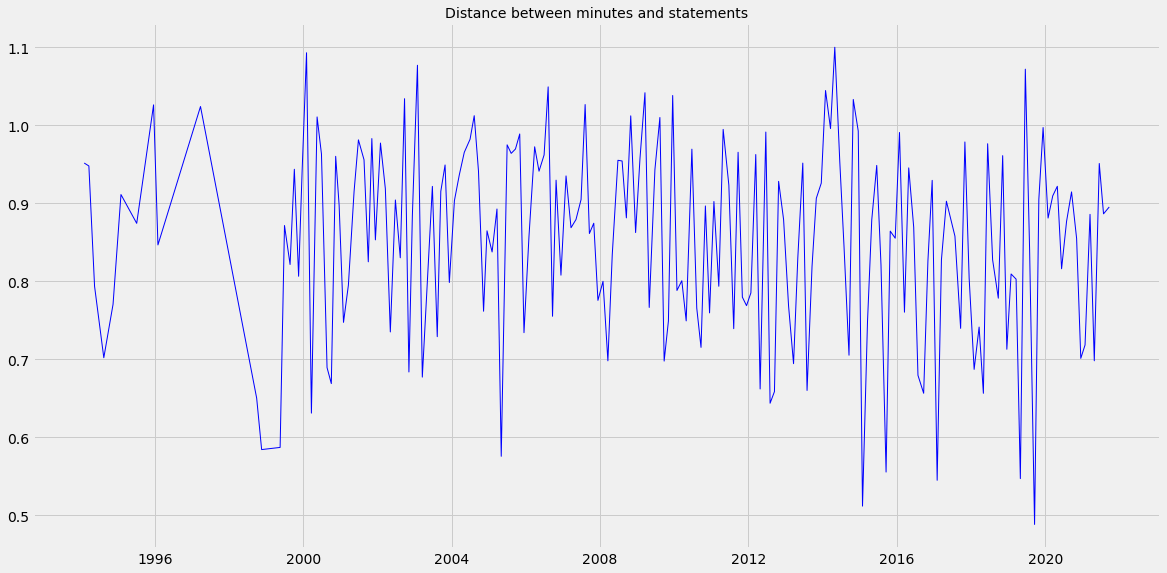

In [35]:
fig, ax = plt.subplots()
ax.plot(df_minutes.index, Distance, c='blue', linewidth=1.0)
plt.title('Distance between minutes and statements', size='medium')
plt.show()

In [36]:
Distance.describe()

count    192.000000
mean       0.853635
std        0.125417
min        0.488226
25%        0.767826
50%        0.874349
75%        0.951542
max        1.100027
dtype: float64

<AxesSubplot:>

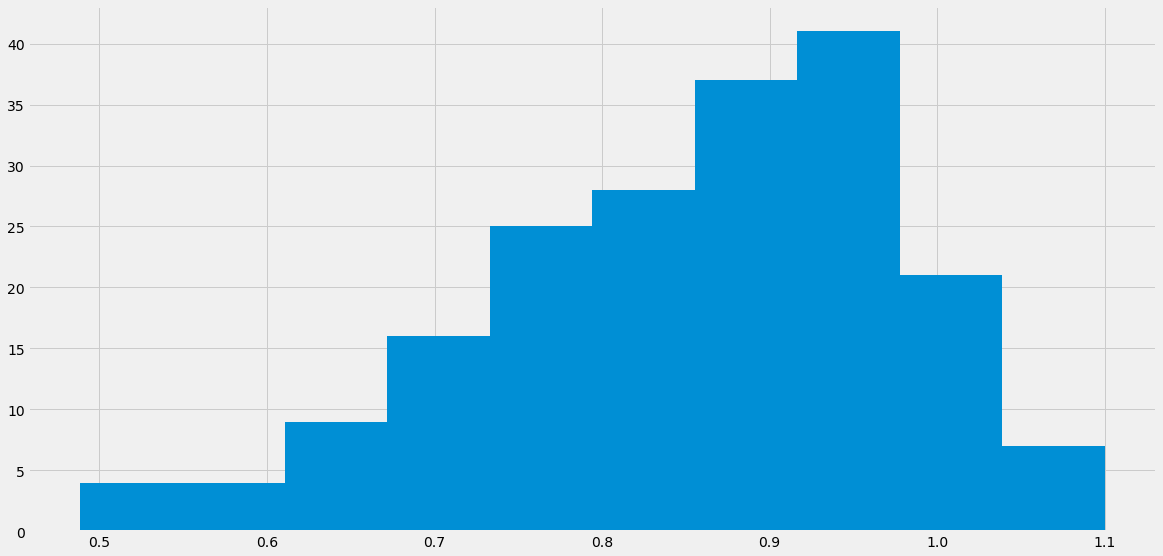

In [37]:
Distance.hist()

### Policy Rate Change and Market Reaction

### Feature Selection and Sentiment